In [1]:
import numpy as np
import pandas as pd
import yaml

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, roc_curve, roc_auc_score, auc, precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns

# Load the configuration file

In [2]:
with open("workspace/config.yml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

lame = config['lame']
path = f"{config['path_to_data']}/{lame}"

# Load the data

In [3]:
# Load the selected peaks in the region with the given frequency
peaks = pd.read_csv(f"{path}/results/mse_spectra_region.csv")

# Round the mass-to-charge ratio to the second decimal
peaks.columns = peaks.columns.astype(float).round(3)

# Load the selected region pixels features
pixels = pd.read_csv(f"{path}/results/mse_pixels_region.csv")

# Remove the Trypsin peaks

In [4]:
# Load the trypsin peaks from a file
with open("workspace/trypsin_peaks.yml", "r") as f:
    trypsin_peaks = yaml.safe_load(f)

# Drop the columns that are in the trypsin peaks with tolerance 0.2
for col in peaks.columns:
    if np.min(np.abs(float(col) - np.array(trypsin_peaks))) < 0.2:
        print(f"Dropping {col}")
        peaks.drop(col, axis=1, inplace=True)

Dropping 515.322
Dropping 842.491
Dropping 906.405
Dropping 1045.55


# Plot the pixels densities extracted from the IHC images

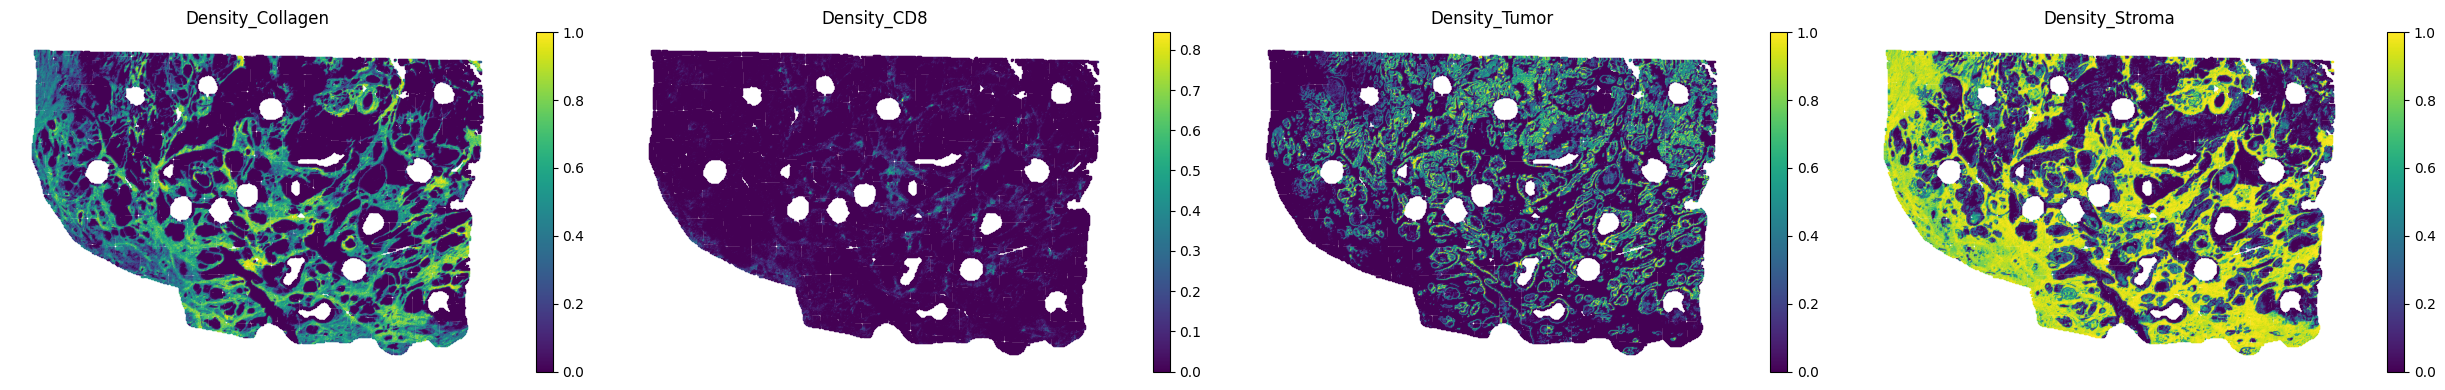

In [5]:
# Determine the densities of the selected pixels
densities = [col for col in pixels.columns if 'Density' in col][2:]

fig, axs = plt.subplots(1, 4, figsize=(25, 4), tight_layout=True)
for ax in axs.flatten():
    ax.axis('off')

for ax, density in zip(axs.flatten(), densities):
    ax.scatter(x=pixels['x_warped'], y=pixels['y_warped'], c=pixels[density], cmap='viridis', s=0.5, marker='s')
    ax.set_title(density)
    ax.invert_yaxis()
    ax.axis('equal')
    fig.colorbar(ax.collections[0], ax=ax)

plt.show()

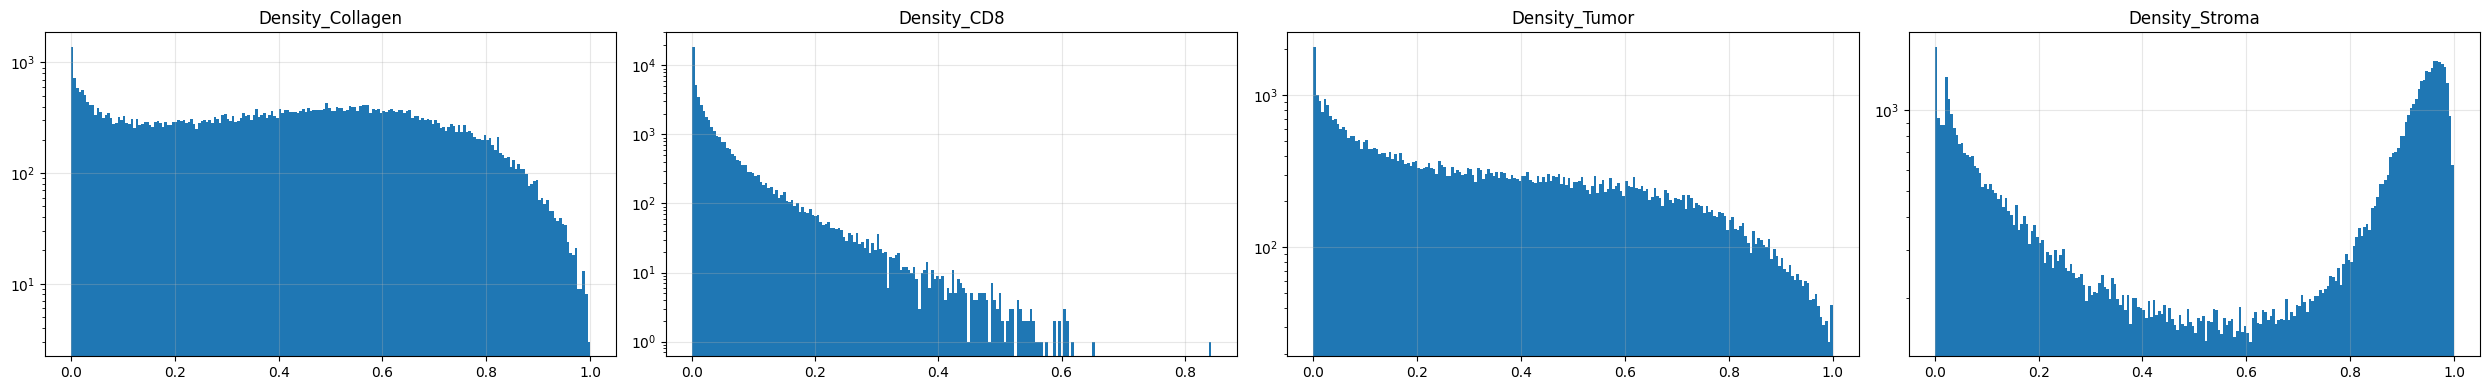

In [6]:
# Make a histogram of the pixel densities data
fig, axs = plt.subplots(1, 4, figsize=(25, 4), tight_layout=True)

for ax, density in zip(axs.flatten(), densities):
    ax.hist(pixels[density][pixels[density] != 0], bins=200)
    ax.set_title(density)
    ax.set_yscale('log')
    ax.grid(alpha=0.3)

plt.show()

# Define a threshold for the pixel densities, then plot the density thresholded masks

In [7]:
threshold = {
    'Density_CD8': 0.03,
    'Density_Tumor': 0.1,
    'Density_Stroma': 0.8,
    'Density_Collagen': 0.5
    }

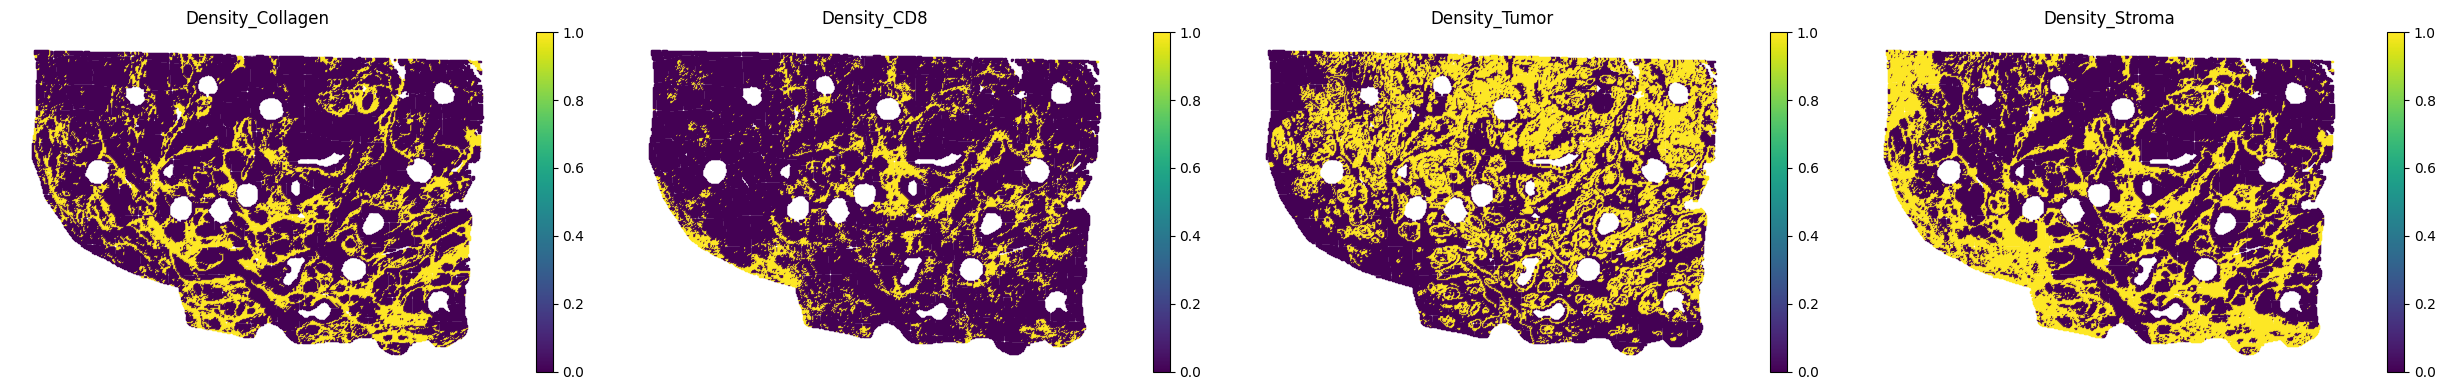

In [8]:
# plot the pixels densities with threshold
fig, axs = plt.subplots(1, 4, figsize=(25, 4), tight_layout=True)
for ax in axs.flatten():
    ax.axis('off')

for ax, density in zip(axs.flatten(), densities):
    ax.scatter(x=pixels['x_warped'], y=pixels['y_warped'], c=pixels[density] > threshold[density], cmap='viridis', s=0.5, marker='s')
    ax.set_title(density)
    ax.invert_yaxis()
    ax.axis('equal')
    fig.colorbar(ax.collections[0], ax=ax)

plt.show()

# Split the data into training and testing sets

In [9]:
# Sample data
X = peaks
y = pixels['Density_CD8']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data into DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Perform the training of the xgboost model

In [10]:
# Define XGBoost regressor parameters
params = {'objective':'reg:squarederror',
          'max_depth':12,
          'learning_rate':0.1,
          'alpha':10,
          'colsample_bytree':0.9,
          'device':"cpu"}

# Initialize the evals_result dictionary
evals_result = {}

# Train the model with evals_result to store the evaluation results
model_reg = xgb.train(params=params,
                      dtrain=dtrain,
                      num_boost_round=1000,
                      evals=[(dtrain, 'train'), (dtest, 'test')],
                      early_stopping_rounds=10,
                      evals_result=evals_result)

[0]	train-rmse:0.04538	test-rmse:0.04573
[1]	train-rmse:0.04464	test-rmse:0.04505
[2]	train-rmse:0.04403	test-rmse:0.04449
[3]	train-rmse:0.04347	test-rmse:0.04401
[4]	train-rmse:0.04301	test-rmse:0.04358
[5]	train-rmse:0.04259	test-rmse:0.04322
[6]	train-rmse:0.04221	test-rmse:0.04290
[7]	train-rmse:0.04187	test-rmse:0.04263
[8]	train-rmse:0.04156	test-rmse:0.04239
[9]	train-rmse:0.04128	test-rmse:0.04216
[10]	train-rmse:0.04105	test-rmse:0.04198
[11]	train-rmse:0.04084	test-rmse:0.04182
[12]	train-rmse:0.04064	test-rmse:0.04168
[13]	train-rmse:0.04046	test-rmse:0.04155
[14]	train-rmse:0.04026	test-rmse:0.04143
[15]	train-rmse:0.04010	test-rmse:0.04134
[16]	train-rmse:0.03995	test-rmse:0.04124
[17]	train-rmse:0.03981	test-rmse:0.04116
[18]	train-rmse:0.03966	test-rmse:0.04107
[19]	train-rmse:0.03951	test-rmse:0.04099
[20]	train-rmse:0.03938	test-rmse:0.04093
[21]	train-rmse:0.03927	test-rmse:0.04085
[22]	train-rmse:0.03915	test-rmse:0.04080
[23]	train-rmse:0.03904	test-rmse:0.04074
[2

In [11]:
# Make predictions
y_pred = model_reg.predict(dtest)

# Compute and print the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.0015569819332445793


In [12]:
# Comput the R2 score
r2_train = r2_score(y_train, model_reg.predict(dtrain))
r2_test  = r2_score(y_test, model_reg.predict(dtest))

print(f"R2 score (train): {r2_train:.2f}")
print(f"R2 score (test): {r2_test:.2f}")
print(f"Pearson correlation (train): {np.corrcoef(y_train, model_reg.predict(dtrain))[0, 1]:.2f}")
print(f"Pearson correlation (test): {np.corrcoef(y_test, y_pred)[0, 1]:.2f}")

R2 score (train): 0.44
R2 score (test): 0.28
Pearson correlation (train): 0.68
Pearson correlation (test): 0.53


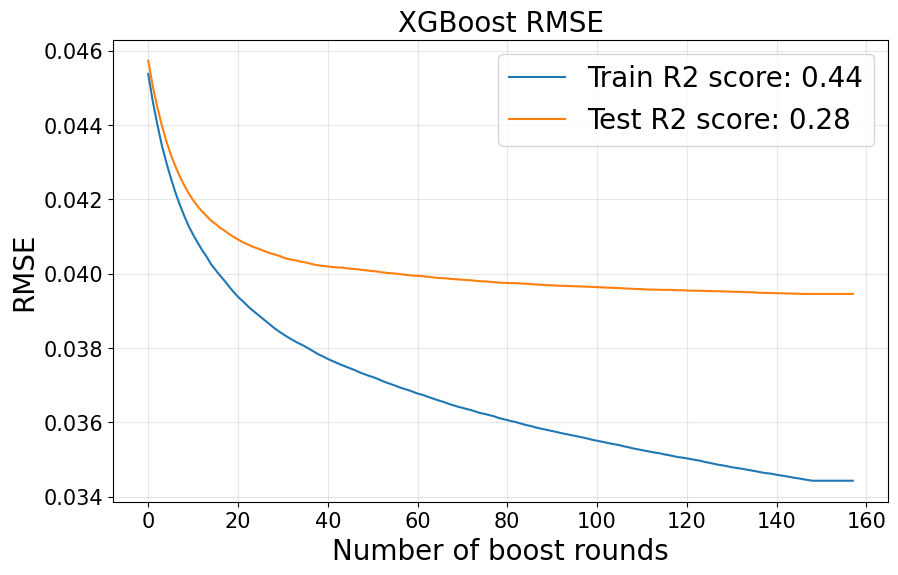

In [13]:
# Plot the training and validation metrics
plt.figure(figsize=(10, 6))
plt.plot(evals_result['train']['rmse'], label=f'Train R2 score: {r2_train:.2f}')
plt.plot(evals_result['test']['rmse'], label=f'Test R2 score: {r2_test:.2f}')
plt.legend(fontsize=20)
plt.ylabel('RMSE', fontsize=20)
plt.xlabel('Number of boost rounds', fontsize=20)
plt.title('XGBoost RMSE', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(alpha=0.3)
plt.show()

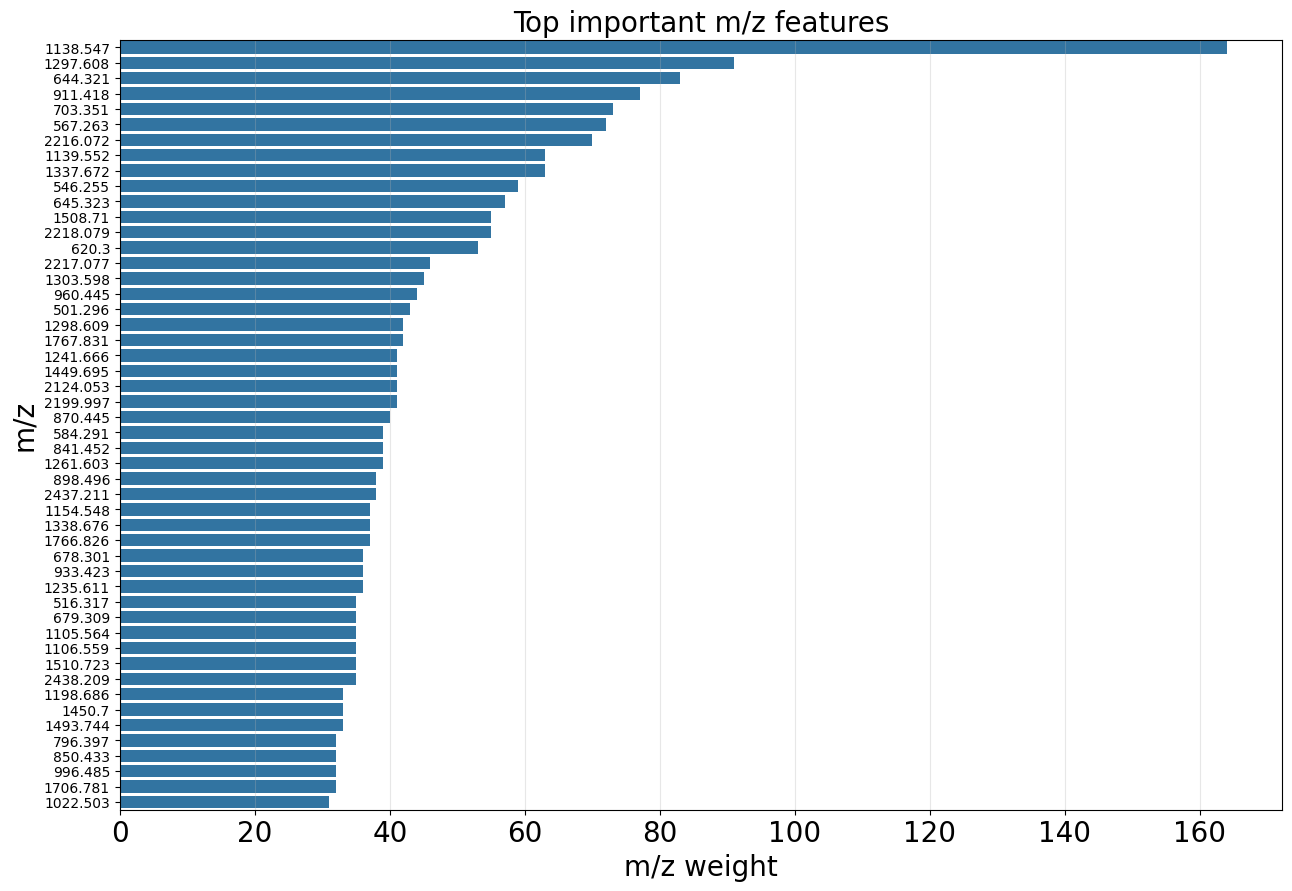

In [14]:
# Compute the feature importance
feature_importance = model_reg.get_score(importance_type='weight')

# Sort the feature importance
feature_importance = dict(sorted(feature_importance.items(), key=lambda item: item[1], reverse=True))

# Plot the top important features
plt.figure(figsize=(15, 10))
sns.barplot(x=list(feature_importance.values())[:50], y=list(feature_importance.keys())[:50])
plt.title('Top important m/z features', fontsize=20)
plt.xlabel('m/z weight', fontsize=20)
plt.ylabel('m/z', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=10)
plt.grid(axis='x', alpha=0.3)
plt.show()

Pearson correlation: 0.65


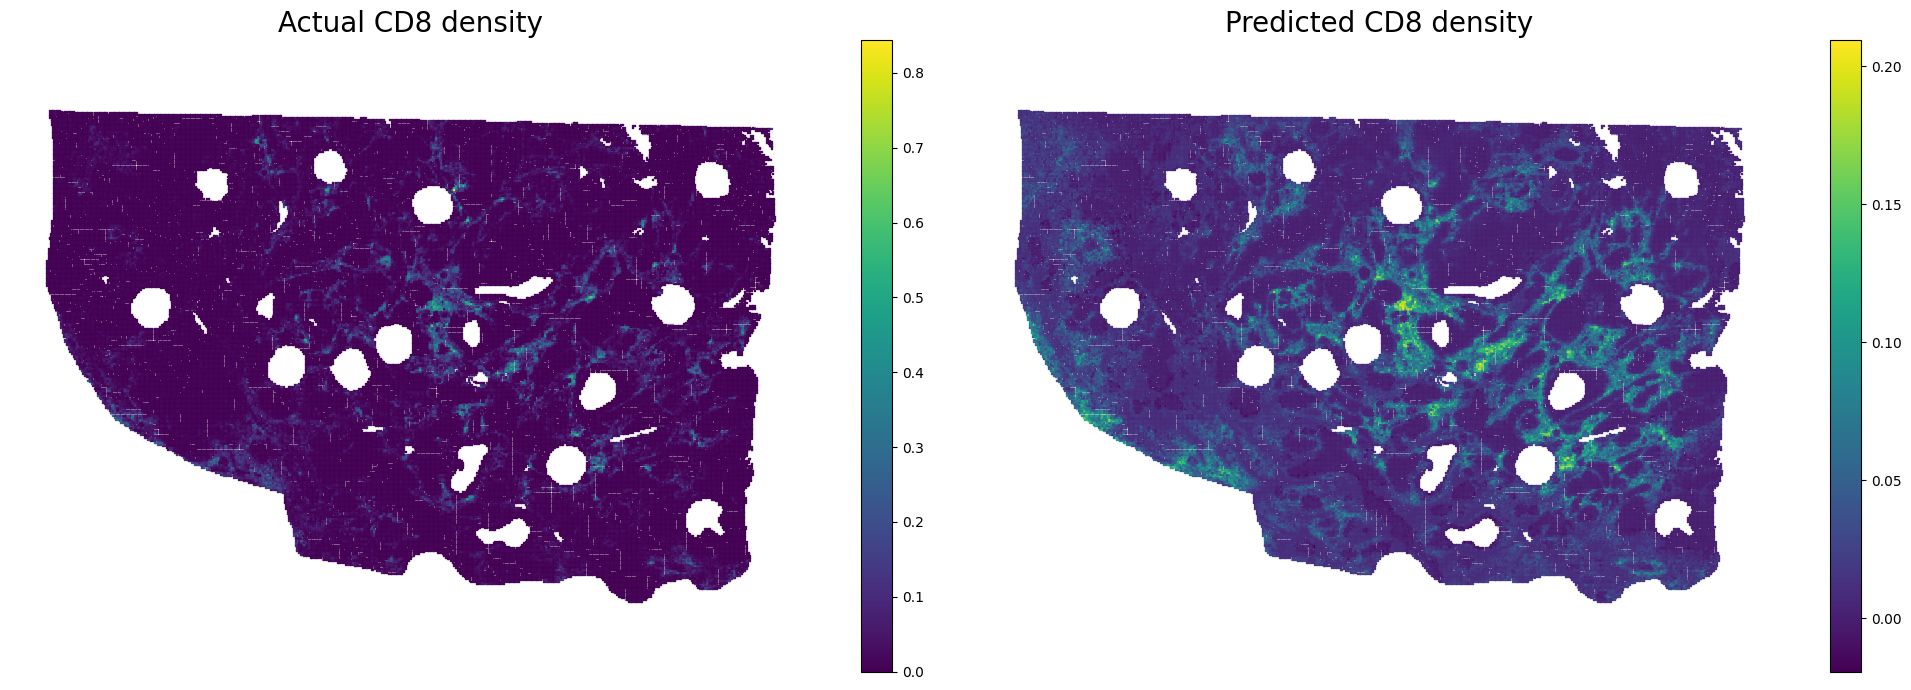

In [15]:
# Load the selected peaks in the region with the given frequency
dall = xgb.DMatrix(peaks)

# Apply the weights to the peaks
predicted_cd8 = model_reg.predict(dall)

# Compute the correlation between the predicted CD8+ T cell density and the actual CD8+ T cell density
print(f"Pearson correlation: {np.corrcoef(pixels["Density_CD8"], predicted_cd8)[0, 1]:.2f}")

# Plot the predicted CD8+ T cell density and the actual CD8+ T cell density
fig, axs = plt.subplots(1, 2, figsize=(20, 7), tight_layout=True)

for ax in axs.flatten():
    ax.axis('off')

axs[0].scatter(x=pixels['x_warped'], y=pixels['y_warped'], c=pixels['Density_CD8'], cmap='viridis', s=0.5, marker='s')
axs[0].set_title('Actual CD8 density', fontsize=20)
axs[0].invert_yaxis()
axs[0].axis('equal')
fig.colorbar(axs[0].collections[0], ax=axs[0])

axs[1].scatter(x=pixels['x_warped'], y=pixels['y_warped'], c=predicted_cd8, cmap='viridis', s=0.5, marker='s')
axs[1].set_title('Predicted CD8 density', fontsize=20)
axs[1].invert_yaxis()
axs[1].axis('equal')
fig.colorbar(axs[1].collections[0], ax=axs[1])

plt.show()

In [16]:
# Compute the Pearson correlation between each mass in the peaks and the CD8 density
corr_pearson = []
for mass in peaks.columns:
    corr = np.corrcoef(peaks[mass], pixels["Density_CD8"])[0, 1]
    corr_pearson.append(corr)

# Compute the Spearman correlation between each mass in the peaks and the CD8 density
corr_spearman = []
for mass in peaks.columns:
    corr = peaks[mass].corr(pixels["Density_CD8"], method='spearman')
    corr_spearman.append(corr)

# Compute the log2 fold change between the CD8 high and low groups
fold_change = []
for mass in peaks.columns:
    high = peaks[mass][pixels["Density_CD8"] > threshold["Density_CD8"]]
    low = peaks[mass][pixels["Density_CD8"] <= threshold["Density_CD8"]]
    fc = np.log2(high.mean() / low.mean())
    fold_change.append(fc)

# Create a dataframe with the peaks and their weights
cd8_peaks = pd.DataFrame(data={'mz': peaks.columns,
                               'corr_pearson': corr_pearson,
                               'corr_spearman': corr_spearman,
                               'fold_change': fold_change})

# Transform the cd8_peaks datatypes
cd8_peaks['mz'] = cd8_peaks['mz'].astype(float)

# Extract the feature importance of the peaks from the xgboost model
cd8_peaks['feature_importance'] = [feature_importance.get(str(mz)) for mz in cd8_peaks['mz']]

# Remove the NaN values from the feature importance
cd8_peaks = cd8_peaks.dropna()

cd8_peaks.head()

,mz,corr_pearson,corr_spearman,fold_change,feature_importance
0,501.296,-0.081927,-0.180495,-2.491669,43.0
1,502.241,-0.112230,-0.245850,-3.645862,2.0
2,503.267,-0.212263,-0.363359,-2.473691,8.0
3,504.254,-0.176564,-0.301447,-2.673168,9.0
4,516.317,-0.209119,-0.392256,-1.748522,35.0


In [17]:
# Extract the peaks with a low correlations and high weights
non_cd8_signal = np.array([(np.abs(cd8_peaks['corr_pearson']) < 0.04) & (np.abs(cd8_peaks['feature_importance']) > 15)])[0]

# Compute how many peaks are in the non_cd8_signal
print(f"Number of peaks with low correlations and high feature importance: {np.sum(non_cd8_signal)}")

cd8_peaks.loc[non_cd8_signal]

Number of peaks with low correlations and high feature importance: 24


,mz,corr_pearson,corr_spearman,fold_change,feature_importance
56,629.302,-0.010821,-0.041470,-0.114037,25.0
62,644.321,-0.002777,-0.078798,-0.043280,83.0
94,700.354,-0.019486,-0.109308,-0.081400,22.0
116,758.362,-0.023759,-0.110946,-0.104198,24.0
165,874.392,-0.013885,-0.106081,-0.105289,16.0
174,898.496,0.030051,-0.019676,0.044542,38.0
201,960.445,0.007768,-0.040116,-0.017700,44.0
209,974.453,0.023332,-0.010378,0.009080,20.0
259,1081.565,0.012395,0.032455,0.196596,17.0
280,1116.480,0.033283,-0.045177,0.032133,17.0


In [18]:
# Wright the mz of the peaks with low correlations and high weights in a file for mascot search
cd8_peaks.loc[non_cd8_signal, 'mz'].to_csv(f"{path}/results/non_cd8_signal.csv", index=False)

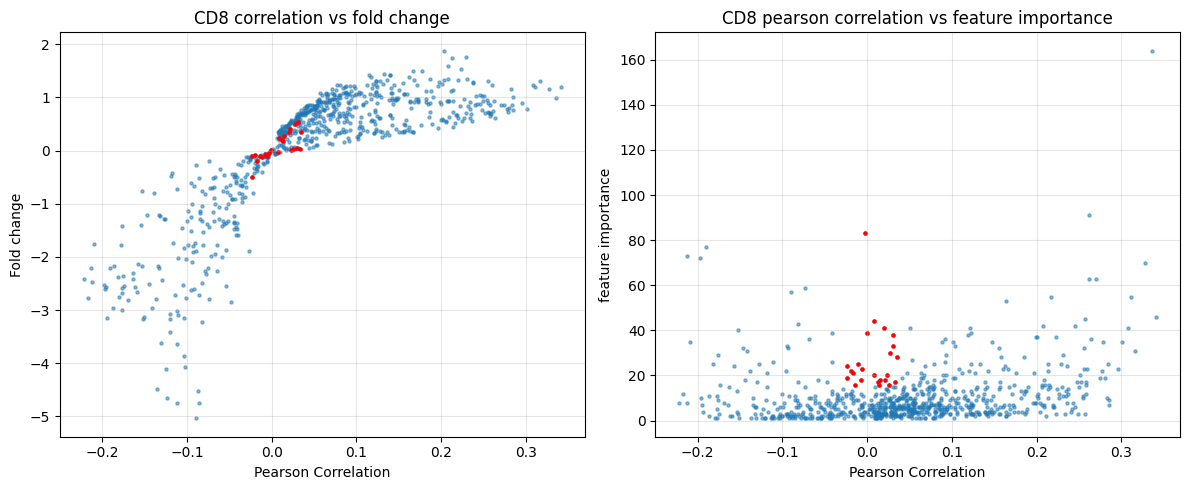

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)
ax = ax.flatten()

ax[0].scatter(cd8_peaks['corr_pearson'], cd8_peaks['fold_change'], alpha=0.5, s=5)
ax[0].scatter(cd8_peaks['corr_pearson'][non_cd8_signal], cd8_peaks['fold_change'][non_cd8_signal], s=5, color='red')

ax[0].set_title("CD8 correlation vs fold change")
ax[0].set_xlabel("Pearson Correlation")
ax[0].set_ylabel("Fold change")
ax[0].grid(alpha=0.3)

ax[1].scatter(cd8_peaks['corr_pearson'], cd8_peaks['feature_importance'], alpha=0.5, s=5)
ax[1].scatter(cd8_peaks['corr_pearson'][non_cd8_signal], cd8_peaks['feature_importance'][non_cd8_signal], s=5, color='red')
ax[1].set_title("CD8 pearson correlation vs feature importance")
ax[1].set_xlabel("Pearson Correlation")
ax[1].set_ylabel("feature importance")
ax[1].grid(alpha=0.3)

plt.show()

In [20]:
# Adjust the y values to be binary
y_train = y_train > threshold['Density_CD8']
y_test = y_test > threshold['Density_CD8']

# Define the logistic regression model
params = {'objective':'binary:logistic',
          'max_depth':12,
          'learning_rate':0.1,
          'alpha':10,
          'colsample_bytree':0.9,
          'device':"cpu"}

# Initialize the evals_result dictionary
evals_result = {}

# Convert the data into DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train the model with evals_result to store the evaluation results
model_log = xgb.train(params=params,
                      dtrain=dtrain,
                      num_boost_round=1000,
                      evals=[(dtrain, 'train'), (dtest, 'test')],
                      early_stopping_rounds=10,
                      evals_result=evals_result)

[0]	train-logloss:0.41736	test-logloss:0.42238
[1]	train-logloss:0.39907	test-logloss:0.40846
[2]	train-logloss:0.38365	test-logloss:0.39711
[3]	train-logloss:0.36984	test-logloss:0.38711
[4]	train-logloss:0.35789	test-logloss:0.37852
[5]	train-logloss:0.34688	test-logloss:0.37129
[6]	train-logloss:0.33697	test-logloss:0.36524
[7]	train-logloss:0.32848	test-logloss:0.35979
[8]	train-logloss:0.32026	test-logloss:0.35490
[9]	train-logloss:0.31268	test-logloss:0.35068
[10]	train-logloss:0.30572	test-logloss:0.34692
[11]	train-logloss:0.29884	test-logloss:0.34352
[12]	train-logloss:0.29297	test-logloss:0.34070
[13]	train-logloss:0.28769	test-logloss:0.33801
[14]	train-logloss:0.28261	test-logloss:0.33569
[15]	train-logloss:0.27805	test-logloss:0.33351
[16]	train-logloss:0.27352	test-logloss:0.33188
[17]	train-logloss:0.26911	test-logloss:0.33022
[18]	train-logloss:0.26486	test-logloss:0.32865
[19]	train-logloss:0.26111	test-logloss:0.32749
[20]	train-logloss:0.25758	test-logloss:0.32640
[2

In [21]:
# Make predictions
y_pred_train = model_log.predict(dtrain) > 0.5
y_pred = model_log.predict(dtest) > 0.5

# Compute the accuracy using accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred)

print(f"Accuracy (train): {accuracy_train:.2f}")
print(f"Accuracy (test): {accuracy_test:.2f}")

Accuracy (train): 0.97
Accuracy (test): 0.86


Accuracy: 0.95


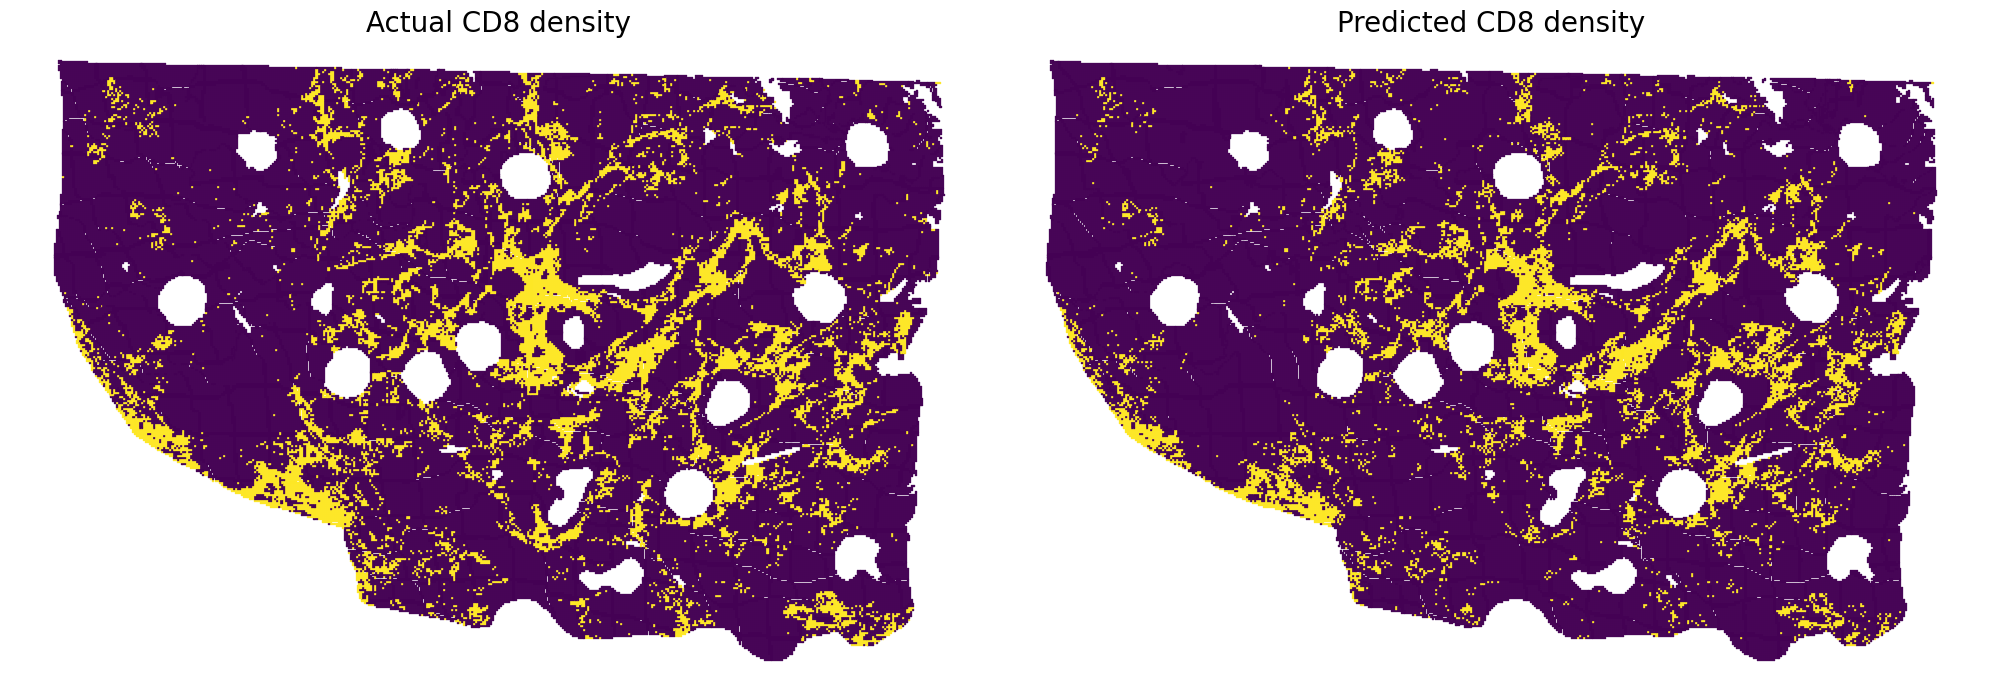

In [22]:
classified_cd8 = model_log.predict(dall) > 0.5

# Compute the accuracy between the predicted CD8+ T cell density and the actual CD8+ T cell density
accuracy_all = accuracy_score(pixels["Density_CD8"] > threshold["Density_CD8"], classified_cd8)

print(f"Accuracy: {accuracy_all:.2f}")

# Plot the predicted CD8+ T cell density and the actual CD8+ T cell density
fig, axs = plt.subplots(1, 2, figsize=(20, 7), tight_layout=True)

for ax in axs.flatten():
    ax.axis('off')

axs[0].scatter(x=pixels['x_warped'], y=pixels['y_warped'], c=pixels['Density_CD8'] > threshold['Density_CD8'], cmap='viridis', s=0.6, marker='s')
axs[0].set_title('Actual CD8 density', fontsize=20)
axs[0].invert_yaxis()
axs[0].axis('equal')

axs[1].scatter(x=pixels['x_warped'], y=pixels['y_warped'], c=classified_cd8, cmap='viridis', s=0.6, marker='s')
axs[1].set_title('Predicted CD8 density', fontsize=20)
axs[1].invert_yaxis()
axs[1].axis('equal')

plt.show()

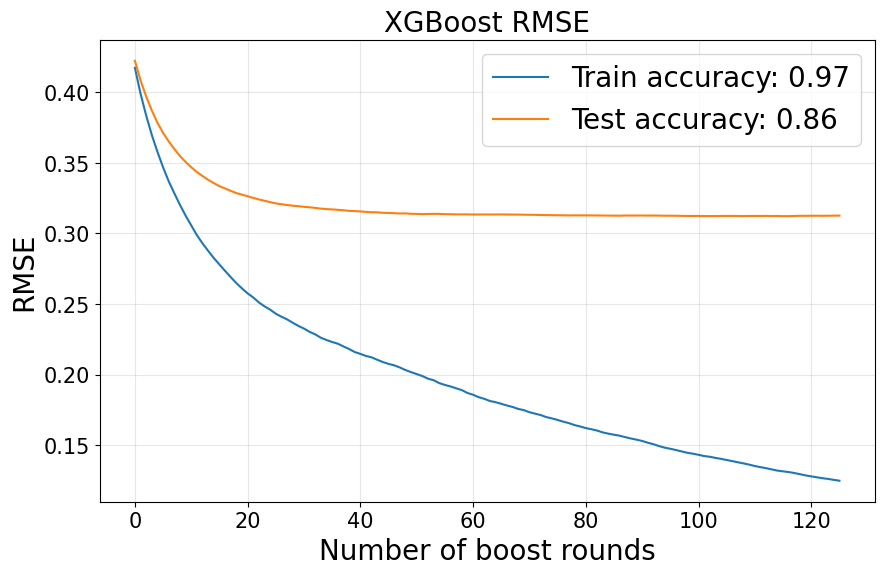

In [23]:
# Plot the training and validation metrics
plt.figure(figsize=(10, 6))
plt.plot(evals_result['train']['logloss'], label=f'Train accuracy: {accuracy_train:.2f}')
plt.plot(evals_result['test']['logloss'], label=f'Test accuracy: {accuracy_test:.2f}')
plt.legend(fontsize=20)
plt.ylabel('RMSE', fontsize=20)
plt.xlabel('Number of boost rounds', fontsize=20)
plt.title('XGBoost RMSE', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(alpha=0.3)
plt.show()

# Sensitivity, specificity and ROC curve

ROC AUC: 0.86
Sensitivity: 0.31
Specificity: 0.97


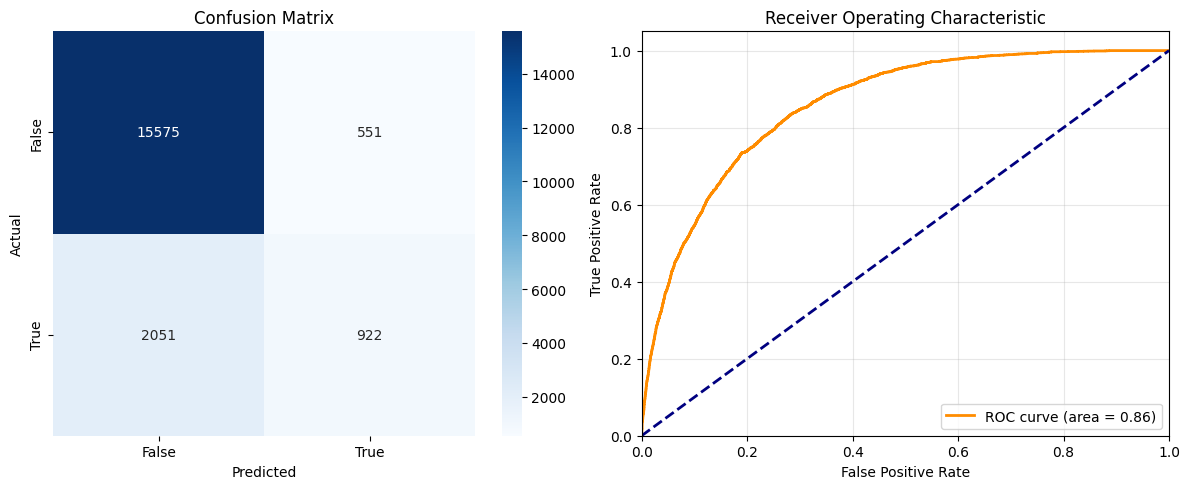

In [24]:
# Compute the True Positives, True Negatives, False Positives and False Negatives
true_positives = np.sum((y_test == 1) & (y_pred == 1))
true_negatives = np.sum((y_test == 0) & (y_pred == 0))
false_positives = np.sum((y_test == 0) & (y_pred == 1))
false_negatives = np.sum((y_test == 1) & (y_pred == 0))

# Compute the Sensitivity and Specificity
sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Compute the confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test, model_log.predict(dtest))

# Compute the ROC AUC
roc_auc = roc_auc_score(y_test, model_log.predict(dtest))

print(f"ROC AUC: {roc_auc:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# Plot the confusion matrix and the ROC curve
fig, ax = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")

ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic')
ax[1].legend(loc="lower right")
ax[1].grid(alpha=0.3)

plt.show()

# Precision and Recall curve

AUC: 0.53
Intersection threshold: 0.31


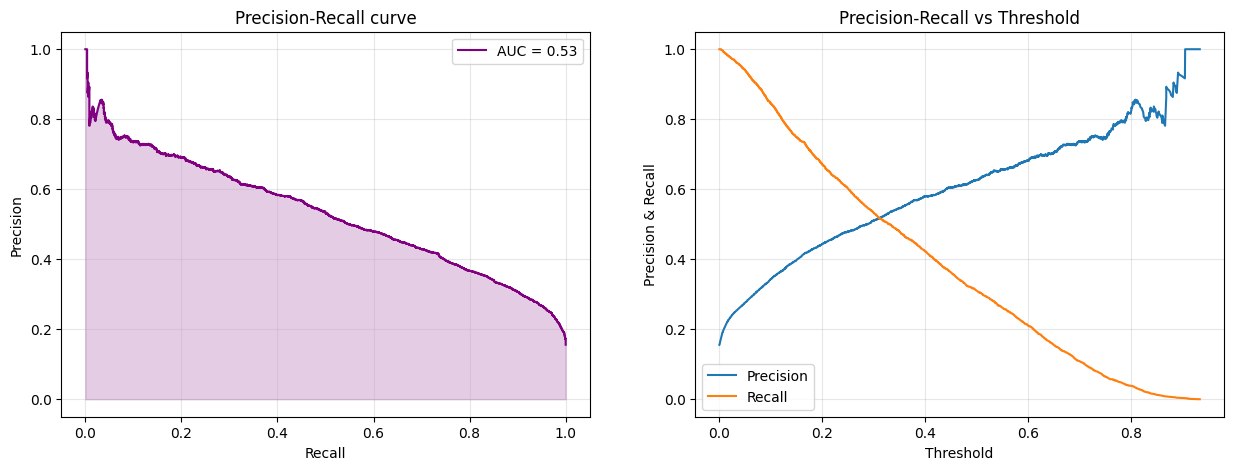

In [25]:
# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, model_log.predict(dtest))

# Compute the AUC
auc_score = auc(recall, precision)

# Calculate the intersection threshold
intersection_threshold = thresholds[np.argmin(np.abs(recall - precision))]

print(f"AUC: {auc_score:.2f}")
print(f"Intersection threshold: {intersection_threshold:.2f}")

# Plot the precision-recall curve
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(recall, precision, color="purple", label=f"AUC = {auc_score:.2f}")
ax[0].fill_between(recall, precision, alpha=0.2, color="purple")
ax[0].set_xlabel("Recall")
ax[0].set_ylabel("Precision")
ax[0].set_title(f"Precision-Recall curve")
ax[0].grid(alpha=0.3)
ax[0].legend()

ax[1].plot(thresholds, precision[:-1], label="Precision")
ax[1].plot(thresholds, recall[:-1], label="Recall")
ax[1].set_xlabel("Threshold")
ax[1].set_ylabel("Precision & Recall")
ax[1].set_title(f"Precision-Recall vs Threshold")
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.show()

Accuracy: 0.85
True Positives: 1538
True Negatives: 14692
False Positives: 1434
False Negatives: 1435
Sensitivity: 0.52
Specificity: 0.91


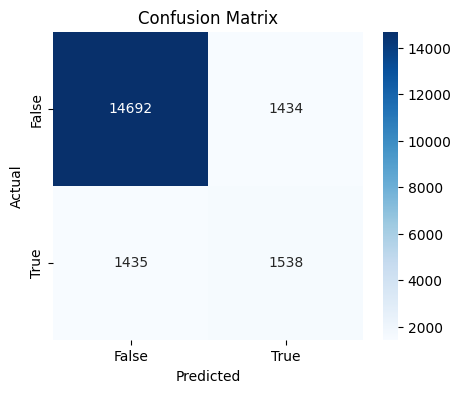

In [26]:
# Predict the CD8 density using the logistic regression model with the intersection threshold
y_pred = model_log.predict(dtest) > intersection_threshold

# Compute the accuracy using accuracy_score
accuracy = accuracy_score(y_test, y_pred)

# Compute the True Positives, True Negatives, False Positives and False Negatives
true_positives = np.sum((y_test == 1) & y_pred)
true_negatives = np.sum((y_test == 0) & ~y_pred)
false_positives = np.sum((y_test == 0) & y_pred)
false_negatives = np.sum((y_test == 1) & ~y_pred)

# Compute the Sensitivity and Specificity
sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Compute the confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

print(f"Accuracy: {accuracy:.2f}")
print(f"True Positives: {true_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()